In [1]:
import parse_data.preprocess as preprocess
import parse_data.loading as loading
from analysis.response_times import calculate_response_times, plot_response_times
import globals
from plotting import plot_octagon, plot_trajectory
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import parse_data.flip_rotate_trajectories as flip_rotate_trajectories
import data_extraction.get_indices as get_indices

### Sandbox for looking generally at trial trajectories (see Demos also)

In [2]:
# paths
# data_folder = '/home/tom/Documents/SWC/data' # desktop Duan Lab
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-53-34_YansuSecondSolo.json' 
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-31-00_YansuJerrySocial.json'
data_folder = r'D:\Users\Tom\OneDrive\PhD\SWC\data' # desktop home
# json_filename = r'first_experiments_2409\240913\2024-09-13_11-23-37_YansuFirstSolo.json'
json_filename = r'first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json'


In [3]:
# Load JSON file into pandas df with collapsed data dictionary and adjustments based on date of recording 
df = loading.loading_pipeline(data_folder, json_filename)

Data is from period before 2024-09-13 11:31:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.


In [4]:
# Pre-process data 
df = preprocess.standard_preprocessing(df)

Preprocessing complete.


In [5]:
## Extract single trials ##

In [6]:
def split_session_by_trial(df):
    ''' return a list of trial dataframes from a session dataframe'''
    
    # groupby produces an interable of tuples with the group key and the dataframe 
    trials_list = [data for _, data in df.groupby('data.trialNum')]
    
    # exclude trial 0 (could also exclude trial 1)
    trials_list = trials_list[1:]

    # if final  trial does not contain a server selected trigger activation, discard it
    if not globals.SELECTED_TRIGGER_ACTIVATION in trials_list[-1]['eventDescription'].unique():
        trials_list = trials_list[:-1]

    return trials_list


In [7]:
trial_list = split_session_by_trial(df)

In [8]:
trial_index = 6

In [9]:
this_trial = trial_list[trial_index]

In [10]:
flip_rotated_trials = []
for i in range(len(trial_list)):
    flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list=trial_list, trial_index=i))

In [11]:
flip_rotated_trial1 = flip_rotate_trajectories.flip_rotate_trajectories(trial_list, trial_index=1)

In [12]:
# find flipped and rotated versions of all trials with a wall separation of 1 (care, this includes forced trials)
single_wall_sep_trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=1)
single_wall_sep_trials = [trial_list[i] for i in single_wall_sep_trial_indices]
flip_rotated_single_wall_sep_trials = []
for i in range(len(single_wall_sep_trials)):
    flip_rotated_single_wall_sep_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(single_wall_sep_trials, trial_index=i))

In [13]:
# find flipped and rotated versions of all trials with a wall separation of 2 (care, this includes forced trials)
double_wall_sep_trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=2)
double_wall_sep_trials = [trial_list[i] for i in double_wall_sep_trial_indices]
flip_rotated_double_wall_sep_trials = []
for i in range(len(double_wall_sep_trials)):
    flip_rotated_double_wall_sep_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(double_wall_sep_trials, trial_index=i))

In [14]:
# find flipped and rotated versions of all trials with a wall separation of 4 (care, this includes forced trials)
triple_wall_sep_trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=4)
triple_wall_sep_trials = [trial_list[i] for i in triple_wall_sep_trial_indices]

flip_rotated_triple_wall_sep_trials = []
for i in range(len(triple_wall_sep_trials)):
    flip_rotated_triple_wall_sep_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(triple_wall_sep_trials, trial_index=i))

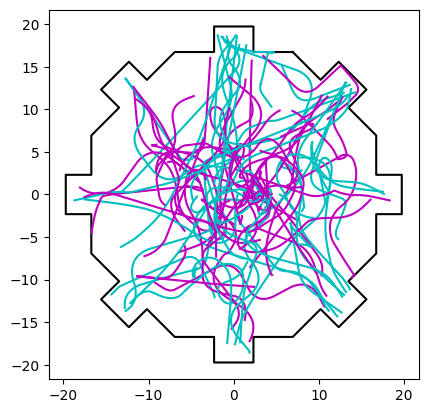

In [15]:
ax = plot_octagon.plot_octagon()
for i in range(len(single_wall_sep_trials)):
    ax = plot_trajectory.plot_trial_trajectory(ax, trial_list=single_wall_sep_trials, trial_index=i)
plt.show()

In [16]:
trigger_event = this_trial[this_trial['eventDescription'] == globals.SELECTED_TRIGGER_ACTIVATION]
trigger_activating_client = trigger_event['data.triggerClient'].values[0]
wall_triggered = trigger_event[globals.WALL_TRIGGERED].item()

In [17]:
wall_triggered

5.0

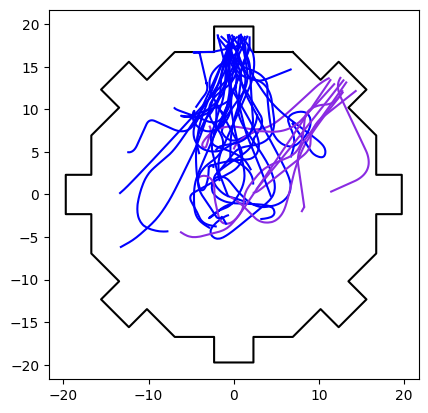

In [18]:
ax = plot_octagon.plot_octagon()
for i in range(len(flip_rotated_single_wall_sep_trials)):
    ax = plot_trajectory.plot_trial_winning_trajectory(ax, trial_list=flip_rotated_single_wall_sep_trials, trial_index=i)
plt.show()

In [19]:
winner_x_locations_slice_onset = []
winner_y_locations_slice_onset = []
winner_ids = []
for i in range(len(flip_rotated_single_wall_sep_trials)):
    this_trial = flip_rotated_single_wall_sep_trials[i]
    winner_id = this_trial[this_trial['eventDescription'] == globals.SELECTED_TRIGGER_ACTIVATION][globals.TRIGGER_CLIENT].values[0]
    winner_ids.append(winner_id)

    xloc_key = globals.PLAYER_LOC_DICT[winner_id]['xloc']
    yloc_key = globals.PLAYER_LOC_DICT[winner_id]['yloc']
    
    this_trial_slice_onset = this_trial[this_trial['eventDescription'] == globals.SLICE_ONSET]

    if not this_trial_slice_onset.empty:
        
        this_trial_slice_onset_index = this_trial_slice_onset.index[0] - this_trial.index[0]
        # print(f"slice onset index is: {this_trial_slice_onset.index[0]}")
        # print(f"trial onset index is: {this_trial.index[0]}")
        # print(f"this_trial_slice_onset_index is: {this_trial_slice_onset_index}")
        
        this_trial_winner_x_location_slice_onset = this_trial[xloc_key].iloc[this_trial_slice_onset_index]
        this_trial_winner_y_location_slice_onset = this_trial[yloc_key].iloc[this_trial_slice_onset_index]

        winner_x_locations_slice_onset.append(this_trial_winner_x_location_slice_onset)
        winner_y_locations_slice_onset.append(this_trial_winner_y_location_slice_onset)
        
    
winner_locations_slice_onset = list(zip(winner_x_locations_slice_onset, winner_y_locations_slice_onset))
winner_locations_slice_onset = np.asarray(winner_locations_slice_onset)

In [30]:
# winner_locations_slice_onset

In [21]:
# start_loc = get_trigger_activators_trial_start_loc(flip_rotated_single_wall_sep_trials)

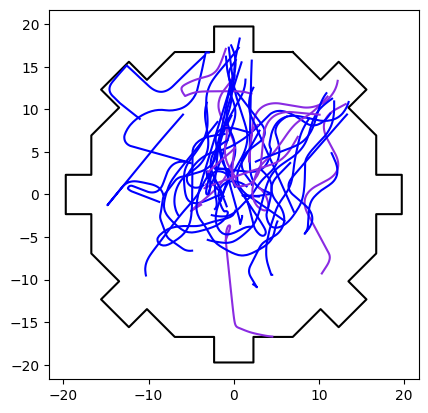

In [22]:
ax = plot_octagon.plot_octagon()
for i in range(len(flip_rotated_single_wall_sep_trials)):
    ax = plot_trajectory.plot_trial_winning_trajectory(ax, trial_list=flip_rotated_single_wall_sep_trials, trial_index=i, loser=True)
plt.show()

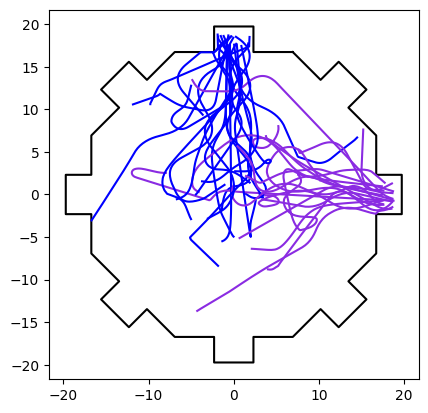

In [23]:
ax = plot_octagon.plot_octagon()
for i in range(len(flip_rotated_double_wall_sep_trials)):
    ax = plot_trajectory.plot_trial_winning_trajectory(ax, trial_list=flip_rotated_double_wall_sep_trials, trial_index=i)
plt.show()

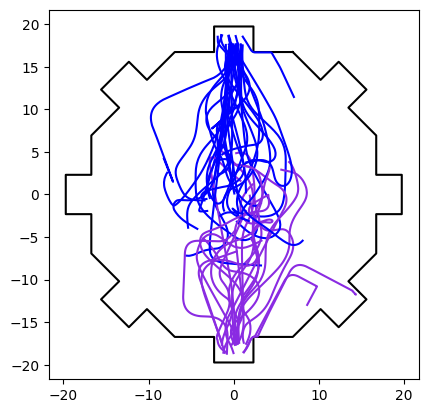

In [24]:
ax = plot_octagon.plot_octagon()
for i in range(len(flip_rotated_triple_wall_sep_trials)):
    ax = plot_trajectory.plot_trial_winning_trajectory(ax, trial_list=flip_rotated_triple_wall_sep_trials, trial_index=i)
plt.show()

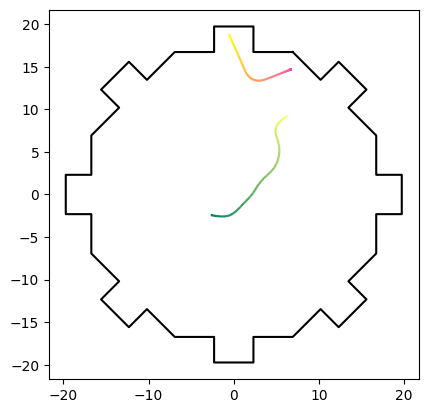

In [25]:
ax = plot_octagon.plot_octagon()
ax = plot_trajectory.plot_trial_trajectory_colour_map(ax, trial=flip_rotated_trial1)

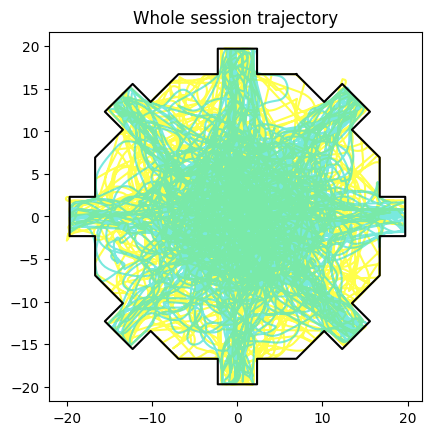

In [26]:
_, ax = plt.subplots()
ax = plot_trajectory.plot_session_trajectory(ax, df, alpha=0.7)
ax = plot_octagon.plot_octagon(ax)

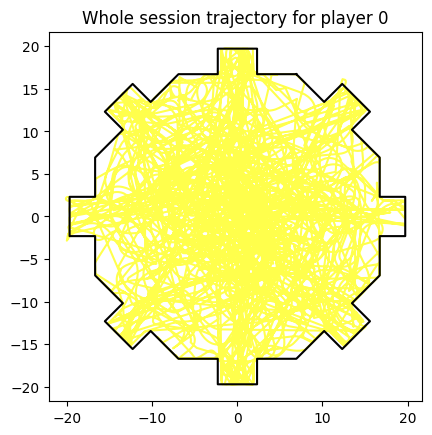

In [27]:
_, ax = plt.subplots()
ax = plot_trajectory.plot_session_trajectory(ax, df, alpha=0.7, chosen_player=0)
ax = plot_octagon.plot_octagon(ax)

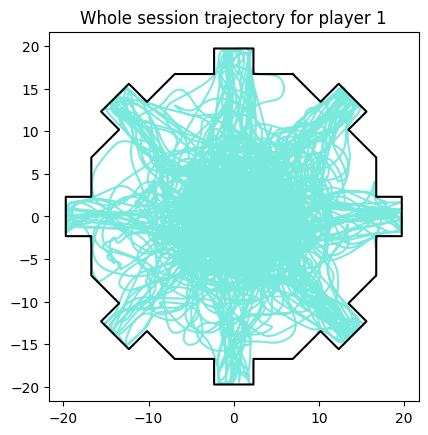

In [28]:
_, ax = plt.subplots()
ax = plot_trajectory.plot_session_trajectory(ax, df, alpha=0.7, chosen_player=1)
ax = plot_octagon.plot_octagon(ax)


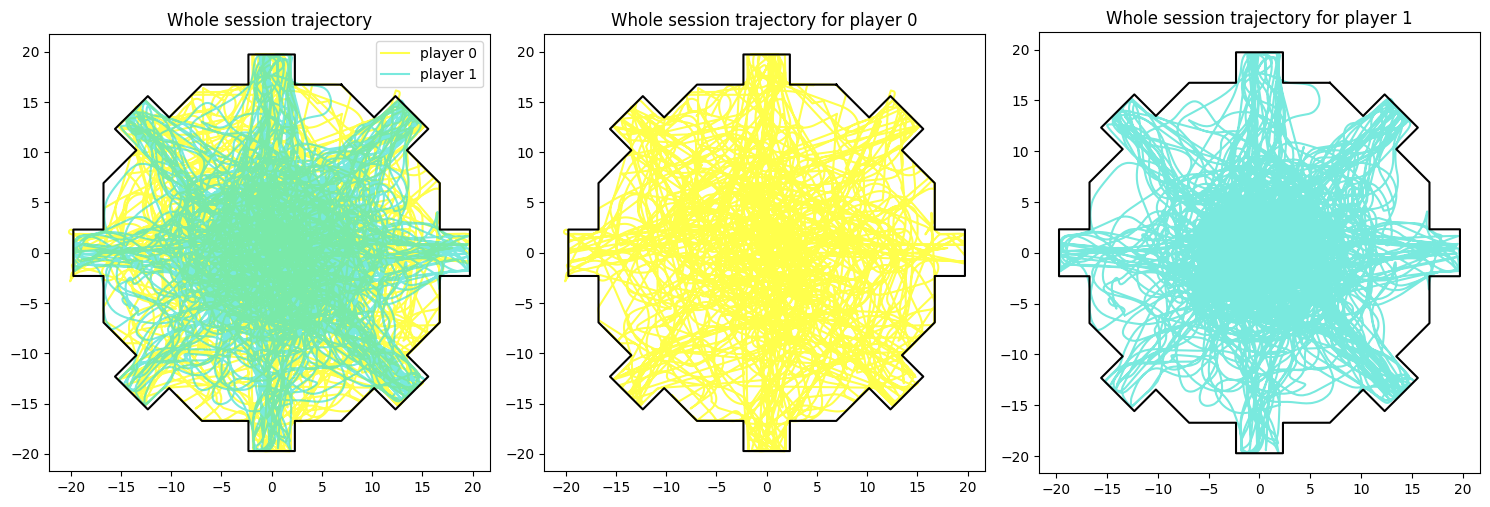

In [29]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

axs[0] = plot_trajectory.plot_session_trajectory(axs[0], df)
axs[0] = plot_octagon.plot_octagon(axs[0])
axs[1] = plot_trajectory.plot_session_trajectory(axs[1], df, chosen_player=0)
axs[1] = plot_octagon.plot_octagon(axs[1])
axs[2] = plot_trajectory.plot_session_trajectory(axs[2], df, chosen_player=1)
axs[2] = plot_octagon.plot_octagon(axs[2])

axs[0].legend()

plt.tight_layout()
